________________

# SIGMOID RNN 
________________

This is the implementation of Sigmoid RNN. The note book is self sufficient in explaining all the work done and tasks of the assignment

________________

### Imports
________________

In [1]:
# UNCOMMENT THIS TO INSTALL REQUIRED LIBRARIES
# !pip install pandas
# !pip install numpy
# !pip install pickle

In [2]:
import numpy as np
import pickle
import pandas as pd

import os, sys
sys.path.append(os.path.abspath('..'))  # Ensure the parent directory of notebooks is in the system path


from models.PRNNSigmoid import PRNNSigmoid
from utils.PRNN_utilsSigmoid import   batch_calculate_grads, check_conditions, check_all_conditions, train_and_val, prepare_folds, process_CVresults, tags2sentence

_________________________

### Conditions 
_________________________
The conditions are stated in the following image. A function <code>check_conditions</code> is written that checks the conditions

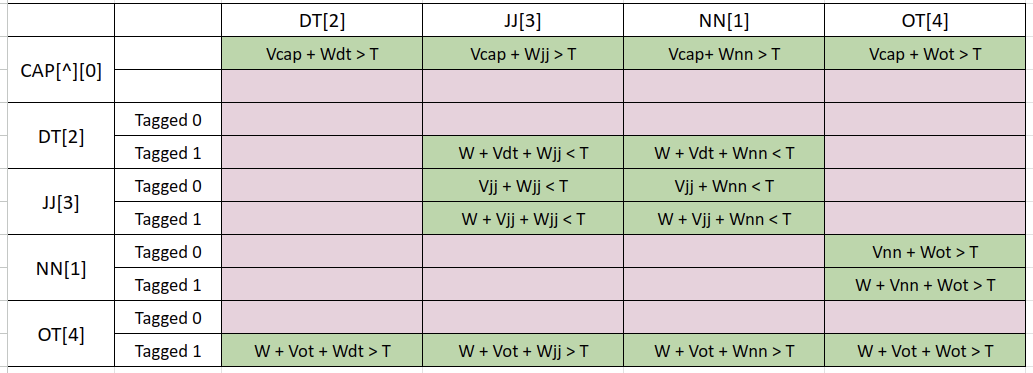

In [3]:
check_conditions(Vcap=1.5, Vnn=.3, Vdt=.1, Vjj=.2, Vot=2.5, 
                T=1.2, Wnn=.3, Wdt=1.3, Wjj=.2, Wot=2.0, W=.10, verbose=True)

print("\nTHIS PROVES THAT THERE ARE POSSIBLE PARAMETERS THAT SATISFY THE CONDITIONS GIVEN ABOVE IN THE TABLE")

Vcap [1.5] + Wdt [1.3] > T [1.2]		SATISFIED
Vcap [1.5] + Wjj [0.2] > T [1.2]		SATISFIED
Vcap [1.5] + Wjj [0.3] > T [1.2]		SATISFIED
Vcap [1.5] + Wjj [2.0] > T [1.2]		SATISFIED

W [0.1] + Vdt [0.1] + Wjj [0.2] < T [1.2]	SATISFIED
W [0.1] + Vdt [0.1] + Wnn [0.3] < T [1.2]	SATISFIED

Vjj [0.2] + Wjj [0.2] < T [1.2]		SATISFIED
Vjj [0.2] + Wnn [0.3] < T [1.2]		SATISFIED
W [0.1] + Vjj [0.2] + Wjj [0.2] < T [1.2]	SATISFIED
W [0.1] + Vjj [0.2] + Wnn [0.3] < T [1.2]	SATISFIED

Vnn [0.3] + Wot [2.0] > T [1.2]	SATISFIED
W [0.1] + Vnn [0.3] + Wot [2.0] > T [1.2]	SATISFIED

W [0.1] + Vot [2.5] + Wdt [1.3] > T [1.2]	SATISFIED
W [0.1] + Vot [2.5] + Wjj [0.2] > T [1.2]	SATISFIED
W [0.1] + Vot [2.5] + Wnn [0.3] > T [1.2]	SATISFIED
W [0.1] + Vot [2.5] + Wot [2.0] > T [1.2]	SATISFIED

ALL INEQUALITIES SATISFIED FOR THE GIVEN PARAMETERS

THIS PROVES THAT THERE ARE POSSIBLE PARAMETERS THAT SATISFY THE CONDITIONS GIVEN ABOVE IN THE TABLE


We also filled the blanks in the table with most probablr logic the table looks like below.

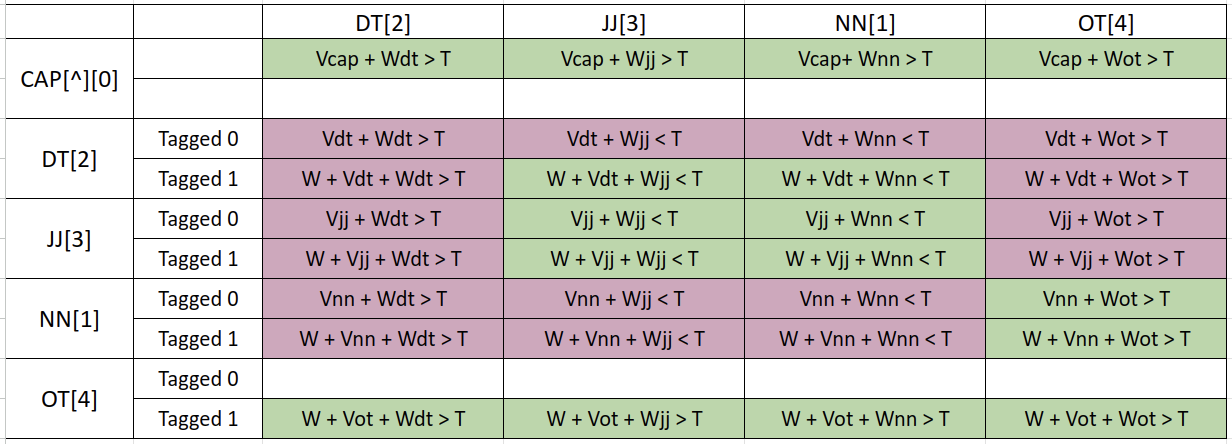

_________________________

### READ DATA
_________________________
Different datasets were filtered out to perform analysis on, These were filtered based on the Inequality rules in above tables

In [4]:
# Read the .jsonl file into a pandas DataFrame
data_train = pd.read_json('../data/train.jsonl', lines=True)    # The whole train DATA
data_test = pd.read_json('../data/test.jsonl', lines=True)        # The whole test DATA

# This is the filtered data according to the GREEN conditions in the FIRST table
con_data_train = pd.read_json('../data/train_conditions.jsonl', lines=True)    # GREEN Conditioned train DATA
con_data_test = pd.read_json('../data/test_conditions.jsonl', lines=True)        # GREEN Conditioned test DATA

# This is the filtered data according to the ALL the conditions in the SECOND table
all_con_data_train = pd.read_json('../data/train_allConditions.jsonl', lines=True)    # ALL Conditioned train DATA
all_con_data_test = pd.read_json('../data/test_allConditions.jsonl', lines=True)        # ALL Conditioned train DATA

_________________________

### Sigmoid Perceptron , Backpropogation and Training
### Q 1. Implement a single recurrent perceptron and BPTT (backpropogation through time) from scratch and train it using the training data provided.
_________________________

### Sol 1. In this section we train a single recurrent perceptron using back propgation through time.

#### 1. Please verify perceptron definition and functionality in <code>PRNNSigmoid.py</code>
#### 2. The BPTT part is implemented in the function in <code>calculate_grads(x, y, model)</code> in the file <code>PRNN_utilsSigmoid.py</code>
#### 3. Below is the training part



In [5]:
# Instantiate the PRNN object
model = PRNNSigmoid()

print("THE PARAMETERS OF THE RNN ARE : \n")
model.view_params()

THE PARAMETERS OF THE RNN ARE : 

PERCEPTRON PARAMETERS
Vcap : -0.3123284815435444 | Vnn : 0.3392847060461844 | Vdt : -0.15590853388271336 | Vjj : -0.5017896732977485 | Vot : 0.2355688917260193
T [Theta] : -1.7636052568042102 | Wnn : -1.0958620439447126 | Wdt : -1.0877657414779511 | Wjj : -0.30517005215449283 | Wot : -0.4737483719561787
W : -0.20059453852255774


##### SPLIT DATA INTO TRAIN AND VAL

In [6]:
TRAIN_RATIO = .75

np.random.seed(42)
# TRAIN-VALIDATION SPLIT 
shuffled_indices = np.random.permutation(data_train.index)
# Train dataframe
train_indices = shuffled_indices[:int(len(data_train)*TRAIN_RATIO)]
train_df = data_train.iloc[train_indices].reset_index(drop=True)

# Val dataframe
val_indices = shuffled_indices[int(len(data_train)*TRAIN_RATIO):]
val_df = data_train.iloc[val_indices].reset_index(drop=True)

##### MODEL HYPERPARAMETER SEARCH
##### Note : The following code takes a large amount of time, It can be skipped as the dictionary <hyperparams.pkl> is already saved

In [7]:
MAX_EPOCHS = 100
all_info = {}   # Contains minimum loss for each congiguration of BATCH_SIZE and LR

In [ ]:
for BATCH_SIZE in [64, 128, 256, 512]:
    for LR in [.001, .005, .01, .05]:

        model = PRNNSigmoid()

        config = f"BATCH_SIZE={BATCH_SIZE}__LR={LR}"

        print("STATING TRAINING FOR " + config )

        train_losses = []
        train_accs = []
        val_losses = []


        for epoch in range(MAX_EPOCHS):

            start_id = 0
            end_id = start_id + BATCH_SIZE

            # Shuffle train data in every epoch
            shuffled_indices = np.random.permutation(train_df.index)
            train_df = train_df.reindex(shuffled_indices).reset_index(drop=True)

            ### Running Model For a single Epoch 
            while(True):

                if end_id > len(train_df)-1: break

                #Batching
                batch = train_df[start_id : end_id]

                # Calculate Gradients
                grad_p, grad_w = batch_calculate_grads(model=model, batch=batch)
                # Gradient Descent Update
                model.gradient_descent_step(grad_p=grad_p, grad_w=grad_w, lr=LR)

                start_id = end_id
                end_id = start_id + BATCH_SIZE


            # Evaluation of model after each epoch
            #print(f"###################### EPOCH {epoch+1} COMPLETE ###################### ")
            
            train_loss = model.batch_CE_loss(batch=train_df)
            train_losses.append(train_loss)

            val_loss = model.batch_CE_loss(batch=val_df)
            val_losses.append(val_loss)
            
            print(f"EPOCH :{epoch}   Train Loss : {np.round(train_loss, 6)} | Val Loss : {np.round(val_loss, 6)}")

        print("COMPLETED EPOCHS FOR " + config + '\n')

        all_info[config] = np.round(np.min(val_losses), 5)



##### SAVE MODEL HYPERPARAMETER INFO AS A DICTIONARY AND CHOOSE BEST HYPERPARAMETERS

In [8]:
#Saving the dictionary to a file using pickle
## UNCOMMENT THIS TO STORE THE DICTIONARY, WE HAVE ALREADY MAD THIS WHILE RUNNING ###

# with open('hyperparamsSigmoid.pkl', 'wb') as f:
#     pickle.dump(all_info, f)

# print("Dictionary saved successfully.")

In [9]:
# Loading the dictionary from the file using pickle
with open('../data/hyperparams2.pkl', 'rb') as f:
    hyperparams = pickle.load(f)

minimum_val_loss  = np.min(list(hyperparams.values()))

In [10]:
for key, val in hyperparams.items():
    if val == minimum_val_loss:
        print("THE FOLLOWING ARE THE BEST HYPERPARAMETERS\n")
        print(key)

THE FOLLOWING ARE THE BEST HYPERPARAMETERS

BATCH_SIZE=64__LR=0.05


_________________________

### CROSS VALIDATION
### Q 2. Use 5-fold cross-validation and report results
_________________________

### Sol 2. In this section we train a single recurrent perceptron using the hyperparameters tuned in the above section. We perform the following in steps

#### 2 a) : Perform 5 fold Cross Val on The WHOLE UNFILTERED DATA
#### 2 b) : Perform 5 fold Cross Val on The FILTERED ACCORDING TO THE CONDITIONS [GREEN]
#### 2 c) : Perform 5 fold Cross Val on The FILTERED ACCORDING TO ALL THE CONDITIONS  [ALL CONDITIONS]

_________________________

_________________________

### 2 a) CROSS VALIDATION on The WHOLE UNFILTERED DATA
_________________________

In [11]:
df_folds = prepare_folds(data=data_train, nof=5)

BATCH_SIZE=64   # Best Hyperparameters Chosen Earlier
LR=0.05         # Best Hyperparameters Chosen Earlier
MAX_EPOCHS = 20
MAX_EPOCHS = 3  # Comment this, use the above one for reproducible results
CVresults_data_sigmoid = {}  # Cross Validation Results
NOF = len(df_folds) # No of FOLDS

In [12]:
for val_fold_index in range(NOF):

    print("##########################################################")
    print(f"STARTED TRAINING FOR VALIDATION FOLD :  {val_fold_index+1}")
    print("##########################################################\n")

    config = f'val_fold_index={val_fold_index}'

    # Choose Folds
    train_df, val_df = train_and_val(df_folds=df_folds, val_index=val_fold_index)

    model = PRNNSigmoid()

    best_val_loss = float('inf')
    best_val_acc = 0
    best_val_sequence_acc = 0
    best_val_epoch = None

    for epoch in range(MAX_EPOCHS):

        start_id = 0
        end_id = start_id + BATCH_SIZE

        # Shuffle train data in every epoch
        shuffled_indices = np.random.permutation(train_df.index)
        train_df = train_df.reindex(shuffled_indices).reset_index(drop=True)


        ### Running Model For a single Epoch 
        while(True):

            if end_id > len(train_df)-1: break

            #Batching
            batch = train_df[start_id : end_id]

            # Calculate Gradients
            grad_p, grad_w = batch_calculate_grads(model=model, batch=batch)
            # Gradient Descent Update
            model.gradient_descent_step(grad_p=grad_p, grad_w=grad_w, lr=LR)

            start_id = end_id
            end_id = start_id + BATCH_SIZE

    

        # Evaluation of model after each epoch

        train_loss, train_acc, train_sen_acc = model.batch_CE_loss(batch=train_df), model.batch_accuracy(batch=train_df), model.batch_sentence_accuracy(batch=train_df)
        val_loss, val_acc, val_sen_acc = model.batch_CE_loss(batch=val_df), model.batch_accuracy(batch=val_df), model.batch_sentence_accuracy(batch=val_df)

        print(f"EPOCH {epoch+1} ------- COMPLETE  ")
        print(f"Train Loss : {np.round(train_loss, 6)} | Train Accuracy : {np.round(train_acc, 6)} | Train Sequence Accuracy : {np.round(train_sen_acc, 6)}")
        print(f"Val Loss : {np.round(val_loss, 6)} | Val Accuracy : {np.round(val_acc, 6)} | Val Sequence Accuracy : {np.round(val_sen_acc, 6)}")

        # STORE THE BEST PARAMETERS
        if val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_epoch = epoch
            best_val_acc = val_acc
            best_val_sequence_acc = val_sen_acc
            best_params = [model.params.copy(), model.w.copy()]


        print()
    
    CVresults_data_sigmoid[config] = [best_val_loss, best_val_acc, best_val_sequence_acc,  best_val_epoch, best_params]
    




##########################################################
STARTED TRAINING FOR VALIDATION FOLD :  1
##########################################################

EPOCH 1 ------- COMPLETE  
Train Loss : 0.573574 | Train Accuracy : 83.684052 | Train Sequence Accuracy : 23.887108
Val Loss : 0.570008 | Val Accuracy : 83.764072 | Val Sequence Accuracy : 25.133499

EPOCH 2 ------- COMPLETE  
Train Loss : 0.536673 | Train Accuracy : 84.251756 | Train Sequence Accuracy : 24.225427
Val Loss : 0.533808 | Val Accuracy : 84.348997 | Val Sequence Accuracy : 24.777501

EPOCH 3 ------- COMPLETE  
Train Loss : 0.514267 | Train Accuracy : 84.191545 | Train Sequence Accuracy : 23.798077
Val Loss : 0.511698 | Val Accuracy : 84.344102 | Val Sequence Accuracy : 24.599502

##########################################################
STARTED TRAINING FOR VALIDATION FOLD :  2
##########################################################

EPOCH 1 ------- COMPLETE  
Train Loss : 0.573773 | Train Accuracy : 83.697823 

In [13]:
# Loading the dictionary from the file using pickle of best saved CV results
# Uncomment this to reproduce model CV results on conditional data : will overide the above results
# with open('../data/CVresults_data_sigmoid.pkl', 'rb') as f:
#     CVresults_data_sigmoid = pickle.load(f)

_ = process_CVresults(CVresults_dict=CVresults_data_sigmoid, summarize=True)

BEST VALIDATION ACCURACY : 84.5053
BEST VALIDATION SEQUENCE ACCURACY : 24.7863

AVERAGE VALIDATION ACCURACY : 84.3253
AVERAGE VALIDATION SEQUENCE ACCURACY : 24.4427


_________________________

### 2 b) CROSS VALIDATION on The FILTERED ACCORDING TO THE CONDITIONS [GREEN]
_________________________

In [14]:
df_folds = prepare_folds(data=con_data_train, nof=5)

BATCH_SIZE=64   # Best Hyperparameters Chosen Earlier
LR=0.05         # Best Hyperparameters Chosen Earlier
MAX_EPOCHS = 20
MAX_EPOCHS = 3  # Comment this, use the above one for reproducible results
CVresults_con_data_sigmoid = {}  # Cross Validation Results
NOF = len(df_folds) # No of FOLDS

In [15]:
for val_fold_index in range(NOF):

    print("##########################################################")
    print(f"STARTED TRAINING FOR VALIDATION FOLD :  {val_fold_index+1}")
    print("##########################################################\n")

    config = f'val_fold_index={val_fold_index}'

    # Choose Folds
    train_df, val_df = train_and_val(df_folds=df_folds, val_index=val_fold_index)

    model = PRNNSigmoid()

    best_val_loss = float('inf')
    best_val_acc = 0
    best_val_sequence_acc = 0
    best_val_epoch = None

    for epoch in range(MAX_EPOCHS):

        start_id = 0
        end_id = start_id + BATCH_SIZE

        # Shuffle train data in every epoch
        shuffled_indices = np.random.permutation(train_df.index)
        train_df = train_df.reindex(shuffled_indices).reset_index(drop=True)


        ### Running Model For a single Epoch 
        while(True):

            if end_id > len(train_df)-1: break

            #Batching
            batch = train_df[start_id : end_id]

            # Calculate Gradients
            grad_p, grad_w = batch_calculate_grads(model=model, batch=batch)
            # Gradient Descent Update
            model.gradient_descent_step(grad_p=grad_p, grad_w=grad_w, lr=LR)

            start_id = end_id
            end_id = start_id + BATCH_SIZE

    

        # Evaluation of model after each epoch

        train_loss, train_acc, train_sen_acc = model.batch_CE_loss(batch=train_df), model.batch_accuracy(batch=train_df), model.batch_sentence_accuracy(batch=train_df)
        val_loss, val_acc, val_sen_acc = model.batch_CE_loss(batch=val_df), model.batch_accuracy(batch=val_df), model.batch_sentence_accuracy(batch=val_df)

        print(f"EPOCH {epoch+1} ------- COMPLETE  ")
        print(f"Train Loss : {np.round(train_loss, 6)} | Train Accuracy : {np.round(train_acc, 6)} | Train Sequence Accuracy : {np.round(train_sen_acc, 6)}")
        print(f"Val Loss : {np.round(val_loss, 6)} | Val Accuracy : {np.round(val_acc, 6)} | Val Sequence Accuracy : {np.round(val_sen_acc, 6)}")

        # STORE THE BEST PARAMETERS
        if val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_epoch = epoch
            best_val_acc = val_acc
            best_val_sequence_acc = val_sen_acc
            best_params = [model.params.copy(), model.w.copy()]


        print()
    
    CVresults_con_data_sigmoid[config] = [best_val_loss, best_val_acc, best_val_sequence_acc,  best_val_epoch, best_params]
    




##########################################################
STARTED TRAINING FOR VALIDATION FOLD :  1
##########################################################

EPOCH 1 ------- COMPLETE  
Train Loss : 0.432599 | Train Accuracy : 79.732054 | Train Sequence Accuracy : 22.865483
Val Loss : 0.426986 | Val Accuracy : 79.627111 | Val Sequence Accuracy : 23.44358

EPOCH 2 ------- COMPLETE  
Train Loss : 0.38328 | Train Accuracy : 79.732054 | Train Sequence Accuracy : 22.865483
Val Loss : 0.375971 | Val Accuracy : 79.627111 | Val Sequence Accuracy : 23.44358

EPOCH 3 ------- COMPLETE  
Train Loss : 0.346655 | Train Accuracy : 84.525095 | Train Sequence Accuracy : 29.384578
Val Loss : 0.338032 | Val Accuracy : 84.46027 | Val Sequence Accuracy : 30.544747

##########################################################
STARTED TRAINING FOR VALIDATION FOLD :  2
##########################################################

EPOCH 1 ------- COMPLETE  
Train Loss : 0.4292 | Train Accuracy : 79.816079 | Trai

In [16]:
# Loading the dictionary from the file using pickle of best saved CV results
# Uncomment this to reproduce model CV results on conditional data : will overide the above results
# with open('../data/CVresults_con_data_sigmoid.pkl', 'rb') as f:
#     CVresults_con_data_sigmoid = pickle.load(f)
    
_ = process_CVresults(CVresults_dict=CVresults_con_data_sigmoid, summarize=True)

BEST VALIDATION ACCURACY : 85.0907
BEST VALIDATION SEQUENCE ACCURACY : 31.1284

AVERAGE VALIDATION ACCURACY : 84.4995
AVERAGE VALIDATION SEQUENCE ACCURACY : 29.6165


_________________________

### 2 c) CROSS VALIDATION on The FILTERED ACCORDING TO ALL THE CONDITIONS  [ALL CONDITIONS]
_________________________

In [17]:
df_folds = prepare_folds(data=all_con_data_train, nof=5)

BATCH_SIZE=64   # Best Hyperparameters Chosen Earlier
LR=0.05         # Best Hyperparameters Chosen Earlier
MAX_EPOCHS = 20
MAX_EPOCHS = 3  # Comment this, use the above one for reproducible results
CVresults_all_con_data_sigmoid = {}  # Cross Validation Results
NOF = len(df_folds) # No of FOLDS

In [18]:
for val_fold_index in range(NOF):

    print("##########################################################")
    print(f"STARTED TRAINING FOR VALIDATION FOLD :  {val_fold_index+1}")
    print("##########################################################\n")

    config = f'val_fold_index={val_fold_index}'

    # Choose Folds
    train_df, val_df = train_and_val(df_folds=df_folds, val_index=val_fold_index)

    model = PRNNSigmoid(seed=16)

    best_val_loss = float('inf')
    best_val_acc = 0
    best_val_sequence_acc = 0
    best_val_epoch = None

    for epoch in range(MAX_EPOCHS):

        start_id = 0
        end_id = start_id + BATCH_SIZE

        # Shuffle train data in every epoch
        shuffled_indices = np.random.permutation(train_df.index)
        train_df = train_df.reindex(shuffled_indices).reset_index(drop=True)


        ### Running Model For a single Epoch 
        while(True):

            if end_id > len(train_df)-1: break

            #Batching
            batch = train_df[start_id : end_id]

            # Calculate Gradients
            grad_p, grad_w = batch_calculate_grads(model=model, batch=batch)
            # Gradient Descent Update
            model.gradient_descent_step(grad_p=grad_p, grad_w=grad_w, lr=LR)

            start_id = end_id
            end_id = start_id + BATCH_SIZE

    

        # Evaluation of model after each epoch

        train_loss, train_acc, train_sen_acc = model.batch_CE_loss(batch=train_df), model.batch_accuracy(batch=train_df), model.batch_sentence_accuracy(batch=train_df)
        val_loss, val_acc, val_sen_acc = model.batch_CE_loss(batch=val_df), model.batch_accuracy(batch=val_df), model.batch_sentence_accuracy(batch=val_df)

        print(f"EPOCH {epoch+1} ------- COMPLETE  ")
        print(f"Train Loss : {np.round(train_loss, 6)} | Train Accuracy : {np.round(train_acc, 6)} | Train Sequence Accuracy : {np.round(train_sen_acc, 6)}")
        print(f"Val Loss : {np.round(val_loss, 6)} | Val Accuracy : {np.round(val_acc, 6)} | Val Sequence Accuracy : {np.round(val_sen_acc, 6)}")

        # STORE THE BEST PARAMETERS
        if val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_epoch = epoch
            best_val_acc = val_acc
            best_val_sequence_acc = val_sen_acc
            best_params = [model.params.copy(), model.w.copy()]


        print()
    
    CVresults_all_con_data_sigmoid[config] = [best_val_loss, best_val_acc, best_val_sequence_acc,  best_val_epoch, best_params]
    




##########################################################
STARTED TRAINING FOR VALIDATION FOLD :  1
##########################################################

EPOCH 1 ------- COMPLETE  
Train Loss : 0.432933 | Train Accuracy : 81.935733 | Train Sequence Accuracy : 27.59786
Val Loss : 0.43636 | Val Accuracy : 81.697639 | Val Sequence Accuracy : 28.040541

EPOCH 2 ------- COMPLETE  
Train Loss : 0.333023 | Train Accuracy : 88.637532 | Train Sequence Accuracy : 54.632498
Val Loss : 0.339556 | Val Accuracy : 87.865394 | Val Sequence Accuracy : 52.364865

EPOCH 3 ------- COMPLETE  
Train Loss : 0.296891 | Train Accuracy : 88.637532 | Train Sequence Accuracy : 54.632498
Val Loss : 0.303607 | Val Accuracy : 87.865394 | Val Sequence Accuracy : 52.364865

##########################################################
STARTED TRAINING FOR VALIDATION FOLD :  2
##########################################################

EPOCH 1 ------- COMPLETE  
Train Loss : 0.434874 | Train Accuracy : 81.886608 | 

In [19]:
# Loading the dictionary from the file using pickle of best saved CV results
# Uncomment this to reproduce model CV results on conditional data : will overide the above results
# with open('../data/CVresults_all_con_data_sigmoid.pkl', 'rb') as f:
#     CVresults_all_con_data_sigmoid = pickle.load(f)

_ = process_CVresults(CVresults_dict=CVresults_all_con_data_sigmoid, summarize=True)

BEST VALIDATION ACCURACY : 88.7792
BEST VALIDATION SEQUENCE ACCURACY : 55.8061

AVERAGE VALIDATION ACCURACY : 88.4829
AVERAGE VALIDATION SEQUENCE ACCURACY : 54.1792


_________________________
### Q3. Report results on the test set with the model trained on the full training data provided.
_________________________

The model was trained on the full train data in part 2a), we use the parameters stores to elavuate the results on test set

In [21]:
model = PRNNSigmoid()  # Instantiate a model

# Set the parameter to the trained checkpoint
P_best, W_best = process_CVresults(CVresults_dict=CVresults_data_sigmoid, summarize=False)
model.params = P_best
model.w = W_best

data_test = pd.read_json('../data/test.jsonl', lines=True)        # The whole test DATA

In [22]:
print(f"TRAIN  ACCURACY : {np.round(model.batch_accuracy(batch=data_train), 4)} %")
print(f"TRAIN SEQUENCE ACCURACY : {np.round(model.batch_sentence_accuracy(batch=data_train), 4)} %")

print()

print(f"TEST  ACCURACY : {np.round(model.batch_accuracy(batch=data_test), 4)} %")
print(f"TEST SEQUENCE ACCURACY : {np.round(model.batch_sentence_accuracy(batch=data_test), 4)} %")


TRAIN  ACCURACY : 84.2708 %
TRAIN SEQUENCE ACCURACY : 24.3359 %

TEST  ACCURACY : 82.0653 %
TEST SEQUENCE ACCURACY : 24.5873 %


_________________________

### Q4. Show error cases and perform analysis
_________________________

Lets first analsye what happens where we take an rnn that satisfies all the inequalities

In [23]:
model = PRNNSigmoid()  # Instantiate a model
model.set_perfect_params()  # set models parameters to satisfy all inequalities

RESETTING TO PERFECT PARAMETERS 

PERCEPTRON PARAMETERS
Vcap : 1.5 | Vnn : 0.3 | Vdt : 0.1 | Vjj : 0.2 | Vot : 2.5
T [Theta] : 1.2 | Wnn : 0.3 | Wdt : 1.3 | Wjj : 0.2 | Wot : 2.0
W : 0.1


In [24]:
# Show that indeed these parameters satidy the inequalities
model.does_RNN_satisfy_conditions()

Vcap [1.5] + Wdt [1.3] > T [1.2]		SATISFIED
Vcap [1.5] + Wjj [0.2] > T [1.2]		SATISFIED
Vcap [1.5] + Wjj [0.3] > T [1.2]		SATISFIED
Vcap [1.5] + Wjj [2.0] > T [1.2]		SATISFIED

W [0.1] + Vdt [0.1] + Wjj [0.2] < T [1.2]	SATISFIED
W [0.1] + Vdt [0.1] + Wnn [0.3] < T [1.2]	SATISFIED

Vjj [0.2] + Wjj [0.2] < T [1.2]		SATISFIED
Vjj [0.2] + Wnn [0.3] < T [1.2]		SATISFIED
W [0.1] + Vjj [0.2] + Wjj [0.2] < T [1.2]	SATISFIED
W [0.1] + Vjj [0.2] + Wnn [0.3] < T [1.2]	SATISFIED

Vnn [0.3] + Wot [2.0] > T [1.2]	SATISFIED
W [0.1] + Vnn [0.3] + Wot [2.0] > T [1.2]	SATISFIED

W [0.1] + Vot [2.5] + Wdt [1.3] > T [1.2]	SATISFIED
W [0.1] + Vot [2.5] + Wjj [0.2] > T [1.2]	SATISFIED
W [0.1] + Vot [2.5] + Wnn [0.3] > T [1.2]	SATISFIED
W [0.1] + Vot [2.5] + Wot [2.0] > T [1.2]	SATISFIED

ALL INEQUALITIES SATISFIED FOR THE GIVEN PARAMETERS


Now we see what is the accuracy on the the trainn data for this model

In [25]:
print(model.batch_accuracy(batch=data_train))

86.88740355857205


This is the point of analysis, even when the inequalities are satisfied, the batch accuracy is not 100%, this is because there are point(samples) where there is ambiguities in the other inequalities. Lets, calculate the accuracy of this model in the filtered dataset 

In [26]:
print('The accurracy for filtered dataset filtered according to first table inequalities')
print(model.batch_accuracy(batch=con_data_train))

The accurracy for filtered dataset filtered according to first table inequalities
97.76505031436479


In [27]:
print('The accurracy for filtered dataset filtered according to second table inequalities')
print(model.batch_accuracy(batch=all_con_data_train))

The accurracy for filtered dataset filtered according to second table inequalities
100.0


We see that as the ambiguity  decreases the model becomes more sure int its predictions and the filnal filtered dataset is nothing but a rule base dataset as seen above the Validation accuracy for it is 100%

_________________________

### Q5. Report model weights and show that the following inequalities hold for the perceptron to satisfy the language constraints.
_________________________

In [28]:
model = PRNNSigmoid()  # Instantiate a model

# Set the parameter to the trained checkpoint
P_best, W_best = process_CVresults(CVresults_dict=CVresults_data_sigmoid, summarize=False)
model.params = P_best
model.w = W_best

model.does_RNN_satisfy_conditions()

Vcap [0.7582] + Wdt [-0.691] > T [-1.7711]		SATISFIED
Vcap [0.7582] + Wjj [-0.3984] > T [-1.7711]		SATISFIED
Vcap [0.7582] + Wjj [-1.3713] > T [-1.7711]		SATISFIED
Vcap [0.7582] + Wjj [-0.4944] > T [-1.7711]		SATISFIED

W [-0.7116] + Vdt [-0.4717] + Wnn [-1.3713] < T [-1.7711]	SATISFIED

Vjj [-0.7062] + Wnn [-1.3713] < T [-1.7711]		SATISFIED
W [-0.7116] + Vjj [-0.7062] + Wjj [-0.3984] < T [-1.7711]	SATISFIED
W [-0.7116] + Vjj [-0.7062] + Wnn [-1.3713] < T [-1.7711]	SATISFIED

Vnn [-0.4936] + Wot [-0.4944] > T [-1.7711]	SATISFIED
W [-0.7116] + Vnn [-0.4936] + Wot [-0.4944] > T [-1.7711]	SATISFIED

W [-0.7116] + Vot [0.5256] + Wdt [-0.691] > T [-1.7711]	SATISFIED
W [-0.7116] + Vot [0.5256] + Wjj [-0.3984] > T [-1.7711]	SATISFIED
W [-0.7116] + Vot [0.5256] + Wnn [-1.3713] > T [-1.7711]	SATISFIED
W [-0.7116] + Vot [0.5256] + Wot [-0.4944] > T [-1.7711]	SATISFIED

ALL INEQUALITIES ARE NOT SATISFIED
[True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, 

In [29]:
model = PRNNSigmoid()  # Instantiate a model

# Set the parameter to the trained checkpoint
P_best, W_best = process_CVresults(CVresults_dict=CVresults_con_data_sigmoid, summarize=False)
model.params = P_best
model.w = W_best

print("The FOLLOWING WEIGHTS SATISFY THE INEQUALITIES\n")
model.view_params()
print()

model.does_RNN_satisfy_conditions()

The FOLLOWING WEIGHTS SATISFY THE INEQUALITIES

PERCEPTRON PARAMETERS
Vcap : 0.236447866657357 | Vnn : -0.17497955625713243 | Vdt : -0.4096560457479913 | Vjj : -0.6930266654480608 | Vot : 0.7789259514892829
T [Theta] : -1.8964898984494674 | Wnn : -1.542486419722308 | Wdt : -0.9379772929434642 | Wjj : -0.3821794266331338 | Wot : 0.032981571410829344
W : -0.1274776925579108

Vcap [0.2364] + Wdt [-0.938] > T [-1.8965]		SATISFIED
Vcap [0.2364] + Wjj [-0.3822] > T [-1.8965]		SATISFIED
Vcap [0.2364] + Wjj [-1.5425] > T [-1.8965]		SATISFIED
Vcap [0.2364] + Wjj [0.033] > T [-1.8965]		SATISFIED

W [-0.1275] + Vdt [-0.4097] + Wnn [-1.5425] < T [-1.8965]	SATISFIED

Vjj [-0.693] + Wnn [-1.5425] < T [-1.8965]		SATISFIED
W [-0.1275] + Vjj [-0.693] + Wnn [-1.5425] < T [-1.8965]	SATISFIED

Vnn [-0.175] + Wot [0.033] > T [-1.8965]	SATISFIED
W [-0.1275] + Vnn [-0.175] + Wot [0.033] > T [-1.8965]	SATISFIED

W [-0.1275] + Vot [0.7789] + Wdt [-0.938] > T [-1.8965]	SATISFIED
W [-0.1275] + Vot [0.7789] + Wjj

In [30]:
model = PRNNSigmoid()  # Instantiate a model

# Set the parameter to the trained checkpoint
P_best, W_best = process_CVresults(CVresults_dict=CVresults_all_con_data_sigmoid, summarize=False)
model.params = P_best
model.w = W_best

print("The FOLLOWING WEIGHTS SATISFY THE INEQUALITIES\n")
model.view_params()
print()

model.does_RNN_satisfy_conditions()

The FOLLOWING WEIGHTS SATISFY THE INEQUALITIES

PERCEPTRON PARAMETERS
Vcap : 0.3878137145638083 | Vnn : -1.3418676327830958 | Vdt : -0.69419259327835 | Vjj : -0.06814670005729997 | Vot : -0.5180068743356376
T [Theta] : -1.5511257397634197 | Wnn : -0.8331683214202812 | Wdt : 0.5611682237792136 | Wjj : -0.7398124904412751 | Wot : 0.8833782376486845
W : 0.3072951171713159

Vcap [0.3878] + Wdt [0.5612] > T [-1.5511]		SATISFIED
Vcap [0.3878] + Wjj [-0.7398] > T [-1.5511]		SATISFIED
Vcap [0.3878] + Wjj [-0.8332] > T [-1.5511]		SATISFIED
Vcap [0.3878] + Wjj [0.8834] > T [-1.5511]		SATISFIED

Vnn [-1.3419] + Wot [0.8834] > T [-1.5511]	SATISFIED
W [0.3073] + Vnn [-1.3419] + Wot [0.8834] > T [-1.5511]	SATISFIED

W [0.3073] + Vot [-0.518] + Wdt [0.5612] > T [-1.5511]	SATISFIED
W [0.3073] + Vot [-0.518] + Wjj [-0.7398] > T [-1.5511]	SATISFIED
W [0.3073] + Vot [-0.518] + Wnn [-0.8332] > T [-1.5511]	SATISFIED
W [0.3073] + Vot [-0.518] + Wot [0.8834] > T [-1.5511]	SATISFIED

ALL INEQUALITIES ARE NOT 

In [31]:
# # SAVE MODEL AFTER TRAINING
# # UNCOMMENT THIS TO SAVE WE HAVE ALREADY SAVED THE MODEL

# with open('CVresults_data_sigmoid.pkl', 'wb') as f:
#     pickle.dump(CVresults_data_sigmoid, f)

# with open('CVresults_con_data_sigmoid.pkl', 'wb') as f:
#     pickle.dump(CVresults_data_sigmoid, f)

# with open('CVresults_all_con_data_sigmoid.pkl', 'wb') as f:
#     pickle.dump(CVresults_data_sigmoid, f)


____________________________________
############################### THANK YOU ###############################
____________________________________